### Importando

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Defining constants

In [2]:
G = 6.67428e-11

AU = (149.6e9)
SCALE = 300/AU

### The body class

In [3]:
class Body:
    ## All vectors are decomposed in x-axis and y-axis
    ## p = (x,y) -> Actual Position Vector
    ## v = (x,y) -> Actual Velocity Vector
    ## pos_x -> List of all x-axis positions over time
    ## pos_y -> List of all y-axis positions over time
    ## color -> Orbit trace and planet color
    
    def __init__(self, name_of = 'UNNAMED', color_of = 'gray'):
        self.name = name_of
        self.color = color_of
        
    
    mass = 0
    v_x = v_y = v_x0 = v_y0 = 0
    p_x = p_y = p_x0 = p_y0 = 0
    pos_x = []
    pos_y = []
    size = 70
    
    ## vec = [self.p_x, self.p_y, self.v_x, self.v_y]
    def acceleration(self, vec):
        acc_x = acc_y = 0
        for other in bodies:
            if self is other:
                continue
            d_x = (other.p_x - vec[0])
            d_y = (other.p_y - vec[1])
            d = math.sqrt(d_x**2 + d_y**2) ## Calculate the distance between the bodies
            if d == 0:
                raise ValueError('The bodies %r and %r collided' %(self.name, other.name))
            
            ## Compute acceleration OTHER causes on THIS
            acc = G * other.mass / d**2
        
            ## Decomposing the acceleration on x-axis and y-axis
            theta = math.atan2(d_y, d_x)
            a_x = acc*math.cos(theta)
            a_y = acc*math.sin(theta)
            
            acc_x += a_x
            acc_y += a_y
        return acc_x, acc_y
    
    def nextDerivative(self, iS, der, dt):
        st = [0,0,0,0]
        st[0] = iS[0] + der[0]*dt
        st[1] = iS[1] + der[1]*dt
        st[2] = iS[2] + der[2]*dt
        st[3] = iS[3] + der[3]*dt
        ax, ay = self.acceleration([st[0],st[1],st[2],st[3]])
        return (st[2], st[3], ax, ay)

### Simulation

### Euler-Cromer

In [4]:
def simulate(bodies, step = 1, period = 365, method = 'euler'):
    step = 24*step*3600 # Total of seconds for each step: 24*3600 = one day
    count = 0
    pos = {}
    
    ## Routine that resets body position state in each simulation
    for body in bodies:
        pos[body.name] = []
        body.p_x = body.p_x0
        body.p_y = body.p_y0
        body.v_x = body.v_x0
        body.v_y = body.v_y0
        
        
    while count < period:
        acc = {}
        for body in bodies:
            a_x, a_y = body.acceleration([body.p_x, body.p_y])
            acc[body] = (a_x,a_y)

        for body in bodies:
            pos[body.name].append((body.p_x,body.p_y))
            
            a_x, a_y = acc[body]               
            if method == 'euler-cromer':
                
                body.v_x += a_x * step
                body.v_y += a_y * step

                body.p_x += body.v_x * step
                body.p_y += body.v_y * step
                
            elif method == 'rk4':
                k1_px = body.v_x * step
                k1_py = body.v_y * step
                k1_vx = a_x * step
                k1_vy = a_x * step
                
                k2_px, k2_py, k2_vx, k2_vy = body.nextDerivative(iS = [body.p_x, body.p_y, body.v_x, body.v_y],der = [k1_px, k1_py, k1_vx, k1_vy], dt = step*0.5)
                
                k3_px, k3_py, k3_vx, k3_vy = body.nextDerivative(iS = [body.p_x, body.p_y, body.v_x, body.v_y],der = [k2_px, k2_py, k2_vx, k2_vy], dt = step*0.5)
       
                k4_px, k4_py, k4_vx, k4_vy = body.nextDerivative(iS = [body.p_x, body.p_y, body.v_x, body.v_y],der = [k3_px, k3_py, k3_vx, k3_vy], dt = step)
                
                body.p_x += (k1_px + 2 * (k2_px + k3_px) + k4_px)/6
                body.p_y += (k1_py + 2 * (k2_py + k3_py) + k4_py)/6
                
                body.v_x += (k1_vx + 2 * (k2_vx + k3_vx) + k4_vx)/6
                body.v_y += (k1_vy + 2 * (k2_vy + k3_vy) + k4_vy)/6
                
            else:
                body.p_x += body.v_x * step
                body.p_y += body.v_y * step
                       
                body.v_x += a_x * step
                body.v_y += a_y * step

        count += 1
    return pos

### Plotter

In [5]:
def orbit_plotter(pos, bodies, title = 'Orbits', scale = False):
    for b in bodies:
        b.pos_x = [i[0] for i in pos[b.name]]
        b.pos_y = [i[1] for i in pos[b.name]]
    
    plt.figure(figsize=(10,10))
    
    for b in bodies:
        plt.plot(b.pos_x, b.pos_y, label = b.name, color = b.color, linestyle=':' )
        plt.scatter(b.pos_x[-1],b.pos_y[-1], color = b.color)
    
    plt.legend()
    plt.grid(alpha=0.2)

    
    ax = plt.gca()
    ax.set_facecolor('black')
    
    if scale == False:
        ### Changing scale of plot
        ticks = ticker.FuncFormatter(lambda x, pos: '{0:.2f}'.format(x/AU))
        ax.xaxis.set_major_formatter(ticks)
        ax.yaxis.set_major_formatter(ticks)
        plt.xlabel('Latitudinal distance in AU')
        plt.ylabel('Longitudinal distance in AU')
    else:
        plt.xlabel('Latitudinal distance in m')
        plt.ylabel('Longitudinal distance in m')
        
    plt.title(title)
    plt.show()
    return ax

In [6]:
sun = Body('Sun', 'yellow')
sun.mass = 1.98892e30
sun.size = 20

earth = Body('Earth', 'blue')
earth.mass = 5.9742e24
earth.p_x0 = -1*AU
earth.v_y0 = 29.783e3
earth.size = 1

venus = Body('Venus', 'pink')
venus.mass = 4.8685e24
venus.p_x0 = 0.723 * AU
venus.v_y0 = -35.02e3
venus.size = 0.95
    
mercury = Body('Mercury', 'purple')
mercury.mass = 0.3e24
mercury.p_x0 = 0.387 * AU
mercury.v_y0 = 47.7e3
mercury.size = 0.38
    
mars = Body('Mars', 'red')
mars.mass = 0.642e24
mars.p_x0 = 1.405 * AU
mars.v_y0 = 24.1e3
mars.size = 0.53
    
jupiter = Body('Jupiter', 'orange')
jupiter.mass = 1.898e27
jupiter.p_x0 = 5.20 * AU
jupiter.v_y0 = 13.1e3
jupiter.size = 11.2
    
saturn = Body('Saturn', 'brown')
saturn.mass = 5.68e26
saturn.p_x0 = 9.58 * AU
saturn.v_y0 = 9.7e3
saturn.size = 9.45
    
uranus = Body('Uranus', 'green')
uranus.mass = 8.6e25
uranus.p_x0 = 19.20 * AU
uranus.v_y0 = 6.8e3
uranus.size = 4
    
neptune = Body('Neptune', 'dodgerblue')
neptune.mass = 1.02e26
neptune.p_x0 = 30.05 * AU
neptune.v_y0 = 5.4e3
neptune.size = 3.8
    
halley = Body('Halley', 'white')
halley.mass = 1.02e14
halley.p_x0 = 35 * AU
halley.v_y0 = 1e3

pluto = Body('Pluto', 'purple')
pluto.mass = 0.0146e24
pluto.p_x0 = 39.48 * AU
pluto.v_y0 = 4.7e3

### Full Solar System

In [15]:
bodies = [sun, earth, venus, mercury, mars, jupiter, saturn, neptune, uranus, pluto, halley]
pos = simulate(bodies, step = 1/(24*3600), period = 5000, method='rk4')

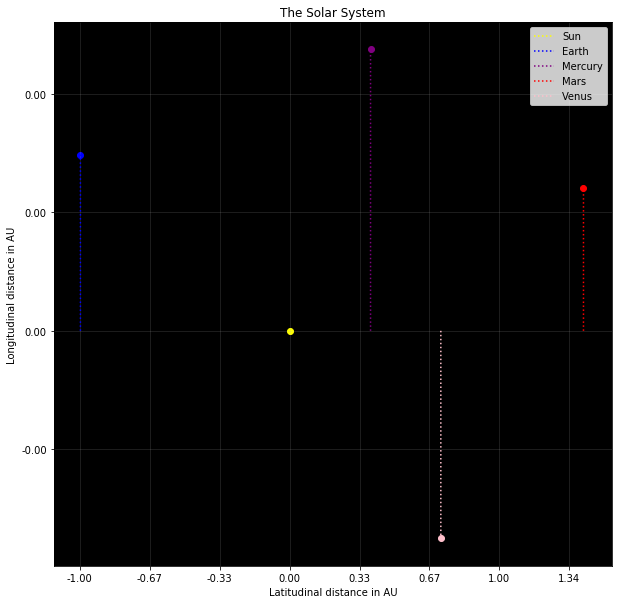

In [16]:
bodies_plot = [sun, earth, mercury, mars, venus]
pl = orbit_plotter(pos, bodies_plot, title='The Solar System', scale=False)

In [ ]:
pos = simulate(bodies, period = 500, method='euler')
pl = orbit_plotter(pos, bodies_plot, title='The Solar System', scale=False)

In [ ]:
prox0 = [abs(i) < 1e8 for i in pl.lines[8].get_data()[1]]
prox0.count(True)

In [ ]:
print(pl.lines[8].get_data()[1])

### Halley

In [ ]:
comet = [sun, halley]
pos = simulate(comet, step = 1, period = 27740)
orbit_plotter(pos, comet, title="Halley's Comet Orbit")

In [ ]:
a = zip(halley.pos_x,halley.pos_y)
for i in a:
    if abs(i[1]) == 0:
        print(i)


## Solar System with Halley

In [ ]:
bodies = [sun, earth, venus, mercury, mars]
bodies_plot = [sun, earth, venus, mercury, mars]
    
pos = simulate(bodies, period = 225, step = 1)
pl = orbit_plotter(pos, bodies_plot, title='The Solar System',scale = True)

In [ ]:
[abs(i) < 0.05e11 for i in venus.pos_y]

In [ ]:
1.495e11,0.3e11

### Inner Solar System

In [ ]:
bodies = [sun, earth, venus, mercury, mars, jupiter, saturn, neptune, uranus, halley]
bodies_plot = [sun, earth, venus, mercury, mars]
    
pos = simulate(bodies, period = 225)
orbit_plotter(pos, bodies_plot, title='The Solar System')

In [ ]:
3600*24

---

## Mudança de dimensões

---

In [ ]:
# G = 6.67428e-11
solar_mass = 1.98892e30
G = 4*math.pi**2

AU = (149.6e9)
SCALE = 300/AU
period = 20000

class Body:
    ## All vectors are decomposed in x-axis and y-axis
    ## p = (x,y) -> Actual Position Vector
    ## v = (x,y) -> Actual Velocity Vector
    ## pos_x -> List of all x-axis positions over time
    ## pos_y -> List of all y-axis positions over time
    ## color -> Orbit trace and planet color
    
    def __init__(self, name_of = 'UNNAMED', color_of = 'gray'):
        self.name = name_of
        self.color = color_of
    
    mass = 0
    v_x = v_y = 0 ## A
    p_x = p_y = 0
    pos_x = []
    pos_y = []
    
    def acceleration(self, other):
        
        if self is other:
            raise ValueError("Attraction of object %r to itself requested"
                             % self.name)
        
        d_x = (other.p_x - self.p_x)
        d_y = (other.p_y - self.p_y)
        d = math.sqrt(d_x**2 + d_y**2) ## Calculate the distance between the bodies
        if d == 0:
            raise ValueError('The bodies %r and %r collided' %(self.name, other.name))
            
        ## Compute acceleration OTHER causes on THIS
        acc = G * self.mass * other.mass / d**2
        
        ## Decomposing the acceleration on x-axis and y-axis
        theta = math.atan2(d_y, d_x)
        a_x = acc*math.cos(theta)
        a_y = acc*math.sin(theta)
        return a_x, a_y
    
def simulate(bodies, days_step = 1):
    step = 1 # Total of seconds for each step: 24*3600 = one day
    count = 0
    pos = {}
    for body in bodies:
        pos[body.name] = []
        
    while count < period:
        acc = {}
        for body in bodies:
            acc_x = acc_y = 0
            for other in bodies:
                if body is other:
                    continue
                a_x, a_y = body.acceleration(other)
                acc_x += a_x
                acc_y += a_y
            acc[body] = (acc_x, acc_y)

        for body in bodies:
            a_x, a_y = acc[body]

            body.v_x += a_x * step
            body.v_y += a_y * step

            body.p_x += body.v_x * step
            body.p_y += body.v_y * step
            
            pos[body.name].append((body.p_x,body.p_y))
        count += 1
    return pos

def orbit_plotter(pos, bodies):
    for b in bodies:
        b.pos_x = [i[0] for i in pos[b.name]]
        b.pos_y = [i[1] for i in pos[b.name]]
    
    plt.figure(figsize=(10,10))
    
    for b in bodies:
        plt.plot(b.pos_x, b.pos_y, label = b.name, color = b.color, linestyle=':' )
        plt.scatter(b.pos_x[-1],b.pos_y[-1], color = b.color)
    
    plt.legend()
    plt.grid(alpha=0.2)
    plt.xlabel('Latitudinal distance in AU')
    plt.ylabel('Longitudinal distance in AU')
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.show()

In [ ]:
def main():
    solar_mass = 1.98892e30
    AU_yr = 4.74371736111
    
    sun = Body('Sun', 'yellow')
    sun.mass = 1

    earth = Body('Earth', 'blue')
    earth.mass = 5.9742e24/solar_mass
    earth.p_x = -1
    earth.v_y = 2*math.pi        # 29.783 km/sec

    # Venus parameters taken from
    # http://nssdc.gsfc.nasa.gov/planetary/factsheet/venusfact.html
    venus = Body('Venus', 'pink')
    venus.mass = 4.8685e24/solar_mass
    venus.p_x = 0.723
    venus.v_y = 3*math.pi
    
    mercury = Body('Mercury', 'purple')
    mercury.mass = 3e25/solar_mass
    mercury.p_x = 0.49
    mercury.v_y = 47.7 / AU_yr
    
    mars = Body('Mars', 'red')
    mars.mass = 6.42e25/solar_mass
    mars.p_x = 1.405
    mars.v_y = 24.1 / AU_yr
    
    jupiter = Body('Jupiter', 'orange')
    jupiter.mass = 1.898e27/solar_mass
    jupiter.p_x = 5.20
    jupiter.v_y = 13.1 / AU_yr
    
    saturn = Body('Saturn', 'brown')
    saturn.mass = 5.68e26/solar_mass
    saturn.p_x = 9.58
    saturn.v_y = 9.7 / AU_yr
    
    uranus = Body('Uranus', 'green')
    uranus.mass = 8.6e25/solar_mass
    uranus.p_x = 19.20
    uranus.v_y = 6.8 / AU_yr
    
    neptune = Body('Neptune', 'dodgerblue')
    neptune.mass = 1.02e26/solar_mass
    neptune.p_x = 30.05
    neptune.v_y = 5.4 / AU_yr
    
    
    bodies = [sun, earth, venus, mercury]
    pos = simulate(bodies, 1)

    orbit_plotter(pos, bodies)
    
if __name__ == '__main__':
    main()    

In [ ]:
sun_m = 1.989e30

1.898e27/sun_m

In [ ]:
1/1047

In [ ]:
3600*24*30*12

In [ ]:
29.783 / 1.496e8

In [ ]:
29.783/4.74371736111


In [ ]:
4*math.pi**2


In [28]:
def RK4Step(s, t, derivs, dt):
    """
    Take a single RK4 step.
    """
    dth=dt/2.0
    f1 = derivs(s, t)
    f2 = derivs(s+f1*dth, t+dth)
    f3 = derivs(s+f2*dth, t+dth)
    f4 = derivs(s+f3*dt, t+dt)
    return s + (f1+2*f2+2*f3+f4)*dt/6.0

/home/gil/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


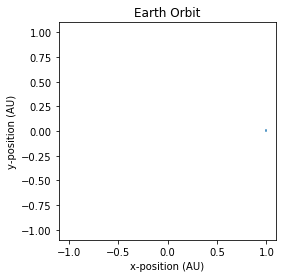

In [30]:
GMs = (2*np.pi)**2   # measure time in years, distance in AU

def derivs_grav(s, step=None):
    """
    Compute motion of Earth about the Sun
    """
    r=s[:2]
    v=s[2:]
    if step==0:  # Verlet space-step
        return np.append(v,np.zeros(2))

    else:
        rnorm = np.sqrt(sum(r*r))
        a = -GMs*r/rnorm**3

        if step is None:  # RK step
            return np.append(v,a)

        else: # Verlet velocity-step
            return np.append(np.zeros(2),a)

v = np.array([0.0,2*np.pi])
r = np.array([1.0,0.0])
s=np.append(r,v)
t=0.0
dt=0.01
tlist=[t]
xlist=[s[0]]
ylist=[s[1]]

while t<1:
    s = RK4Step(s, t, derivs_grav, dt)
    t += dt
    tlist.append(t)
    xlist.append(s[0])
    ylist.append(s[1])


plt.title("Earth Orbit")
plt.xlabel("x-position (AU)")
plt.ylabel("y-position (AU)")
plt.axes().set_aspect('equal')
plt.axis([-1.1,1.1,-1.1,1.1])
plt.plot(xlist, ylist)